In [1]:
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy.constants as const
import jax.numpy as jnp
import jax
import jax.random as random
from copy import deepcopy
import time


In [2]:
#Some lenstronomy imports
import lenstronomy
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
# import the lens equation solver class (finding image plane positions of a source position)
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
# # import lens model solver with 4 image positions constrains
# from lenstronomy.LensModel.Solver.solver4point import Solver4Point


In [3]:
# from helens import LensEquationSolver
import pandas as pd
from collections import OrderedDict
from functools import partial
from herculens.Util import param_util, plot_util
# from herculens.Util import param_util
import functools
import herculens as hcl
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
import jax
jax.config.update("jax_enable_x64", True)


/users/souvik.jana/miniconda3/envs/herculens-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
key = random.PRNGKey(42)
key


Array([ 0, 42], dtype=uint32)

In [5]:
# probabilistic model and variational inference
import numpyro
import numpyro.distributions as dist
from numpyro import infer
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLowRankMultivariateNormal
# NUTS Hamiltonian MC sampling
import blackjax
# import numpyro.constraints as constraints


# #Helens
# from helens import LensEquationSolver


In [6]:
import dynesty
from dynesty import plotting as dyplot
import corner 
import matplotlib.pyplot as plt


In [7]:
# Load JAX cosmology functions from the separate module
from jaxcosmo import JAXCosmology 
from astropy.cosmology import FlatLambdaCDM

import lensimage_gw
from fisher import FisherMatrix
import corner_plot


In [8]:
# Create JAX cosmology instance with the same parameters
jax_cosmo = JAXCosmology(H0=67.3, Om0=0.316)
astropy_cosmo = FlatLambdaCDM(H0=67.3, Om0=0.316)
print("JAX Cosmology Functions Loaded!")
print(f"Parameters: H0 = {jax_cosmo.H0} km/s/Mpc, Om0 = {jax_cosmo.Om0}, Ode0 = {jax_cosmo.Ode0}")
print(f"Hubble distance: {jax_cosmo.hubble_distance:.2f} Mpc")
print(f"Astropy Cosmology: H0 = {astropy_cosmo.H0} km/s/Mpc, Om0 = {astropy_cosmo.Om0}, Ode0 = {astropy_cosmo.Ode0}")
print(f"Hubble distance: {astropy_cosmo.hubble_distance:.2f} Mpc")


JAX Cosmology Functions Loaded!
Parameters: H0 = 67.3 km/s/Mpc, Om0 = 0.316, Ode0 = 0.6839999999999999
Hubble distance: 4454.57 Mpc
Astropy Cosmology: H0 = 67.3 km / (Mpc s) km/s/Mpc, Om0 = 0.316, Ode0 = 0.6839999999999999
Hubble distance: 4454.57 Mpc Mpc


In [9]:
arcsecond_to_radians = (1*u.arcsecond).to(u.radian).value #4.84814e-6


In [10]:
#Setup the lens
zs_true = 2.0; zl_true = 0.5
phi_true = 8.0 # position angle, here in degree
q_true = 0.75 # axis ratio, b/a
e1_true, e2_true = param_util.phi_q2_ellipticity(phi_true * jnp.pi / 180, q_true) # conversion to ellipticities
print(e1_true, e2_true)
theta_E_true = 5.0 # Einstein radius
y0true = 0.3
y1true = 0.2
# y_true = jnp.array([y0true, y1true])
cx0_true, cy0_true = 0.0, 0.0 # position of the lens

lens_mass_model  = MassModel(["SIE", 'SHEAR'])
# lens_mass_model_input = hcl.MassModel([hcl.SIE(), hcl.Shear()])


#SIS for validation and first pass
# kwargs_lens_true_sis = [
#     {'theta_E': theta_E_true, 'center_x': cx0_true, 'center_y': cy0_true}  # SIS
# ]
kwargs_lens_true_sie = [
    {'theta_E': theta_E_true, 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true}  # SIE
]

# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.0001
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * jnp.pi / 180, gamma_ext)
print(gamma1, gamma2)
kwargs_lens_true_sie_shear = [
    {'theta_E': theta_E_true, 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]


0.13732309941975984 0.03937676511671417
-3.090169943749473e-05 9.510565162951537e-05


In [11]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver


# Define classes for lenstronomy
lensModel = LensModel(lens_model_list=['SIE','SHEAR'],z_lens = zl_true, z_source=zs_true)
solver = LensEquationSolver(lensModel)

# Convert JAX arrays to regular Python floats for lenstronomy compatibility
kwargs_lens_true_sie_shear_fixed = [
    {
        'theta_E': float(theta_E_true), 
        'e1': float(e1_true), 
        'e2': float(e2_true), 
        'center_x': float(cx0_true), 
        'center_y': float(cy0_true)
    },
    {
        'gamma1': float(gamma1),
        'gamma2': float(gamma2),
        'ra_0': float(0.0),
        'dec_0': float(0.0)
    }
]

# Convert source positions to regular Python floats
y0true_float = float(y0true)
y1true_float = float(y1true)

print("Fixed lens parameters for lenstronomy:")
print(f"  theta_E: {kwargs_lens_true_sie_shear_fixed[0]['theta_E']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['theta_E'])})")
print(f"  e1: {kwargs_lens_true_sie_shear_fixed[0]['e1']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['e1'])})")
print(f"  e2: {kwargs_lens_true_sie_shear_fixed[0]['e2']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['e2'])})")
print(f"  source position: ({y0true_float}, {y1true_float})")

# compute image position of full model (with numerical options attached)
x_image_true, y_image_true = solver.image_position_from_source(
    kwargs_lens=kwargs_lens_true_sie_shear_fixed,
    sourcePos_x=y0true_float, 
    sourcePos_y=y1true_float,
    min_distance=0.01, 
    search_window=15, 
    precision_limit=10**(-10), 
    num_iter_max=1200,
    solver='lenstronomy'
)
print('image positions (x coordinates): ', x_image_true)
print('image positions (y coordinates): ', y_image_true)

# check solver precision by ray-tracing the image positions back into the source plane
x_source_new, y_source_new = lensModel.ray_shooting(x_image_true, y_image_true, kwargs_lens_true_sie_shear_fixed)
print('x_source_new:',x_source_new)
print('y_source_new:',y_source_new)
print("the relative precision of the image positions are: ", x_source_new - y0true_float)


Fixed lens parameters for lenstronomy:
  theta_E: 5.0 (type: <class 'float'>)
  e1: 0.13732309941975984 (type: <class 'float'>)
  e2: 0.03937676511671417 (type: <class 'float'>)
  source position: (0.3, 0.2)


image positions (x coordinates):  [ 0.93983855  2.90057564  5.01972316 -4.25658029]
image positions (y coordinates):  [ 5.33193565 -4.22283481 -0.4382769  -1.10487159]
x_source_new: [0.3 0.3 0.3 0.3]
y_source_new: [0.2 0.2 0.2 0.2]
the relative precision of the image positions are:  [ 2.89895330e-11 -2.20640173e-12 -3.99619782e-11  4.04459799e-12]


Using fixed parameters for plotting:
  theta_E: 5.0 (type: <class 'float'>)
  source position: (0.3, 0.2)


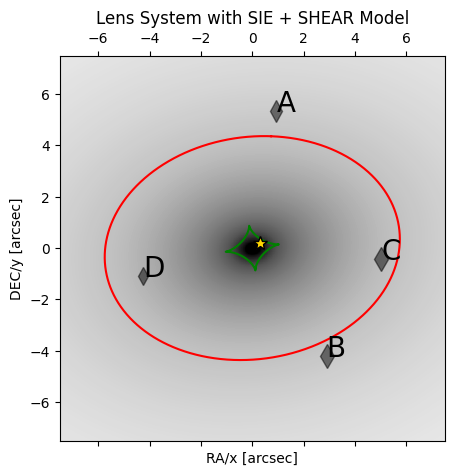

In [12]:
# Plot the lens system (FIXED VERSION)
from lenstronomy.Plots import lens_plot
import matplotlib.pyplot as plt

# Use the fixed parameters (converted to Python floats) for plotting
f, axex = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)

# Make sure we have the fixed parameters available
if 'kwargs_lens_true_sie_shear_fixed' not in locals():
    # Convert JAX arrays to regular Python floats for lenstronomy compatibility
    kwargs_lens_true_sie_fixed = [
        {
            'theta_E': float(theta_E_true), 
            'e1': float(e1_true), 
            'e2': float(e2_true), 
            'center_x': float(cx0_true), 
            'center_y': float(cy0_true)
        },
        {
            'gamma1': float(gamma1),
            'gamma2': float(gamma2),
            'ra_0': float(0.0),
            'dec_0': float(0.0)
        }
    ]
    y0true_float = float(y0true)
    y1true_float = float(y1true)

print("Using fixed parameters for plotting:")
print(f"  theta_E: {kwargs_lens_true_sie_shear_fixed[0]['theta_E']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['theta_E'])})")
print(f"  source position: ({y0true_float}, {y1true_float})")

lens_plot.lens_model_plot(axex, lensModel=lensModel, kwargs_lens=kwargs_lens_true_sie_shear_fixed, 
                          sourcePos_x=y0true_float, sourcePos_y=y1true_float, 
                          point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False,
                         numPix=1000, deltaPix=0.015,cmap_string="gist_heat")

plt.title("Lens System with SIE + SHEAR Model")
plt.show()


In [13]:
## Set up EM observation


In [14]:
npix = 200  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * jnp.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = hcl.PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")


image size : (200, 200) pixels
pixel size : 0.08 arcsec
x range    : (Array(-7.96, dtype=float64), Array(7.96, dtype=float64)) arcsec
y range    : (Array(-7.96, dtype=float64), Array(7.96, dtype=float64)) arcsec


In [15]:
psf = hcl.PSF(psf_type='GAUSSIAN', fwhm=0.3, pixel_size=pix_scl)

background_rms_simu = 1e-2
exposure_time_simu = 1e3
noise_simu = hcl.Noise(npix, npix, background_rms=background_rms_simu, exposure_time=exposure_time_simu)
noise = hcl.Noise(npix, npix, exposure_time=exposure_time_simu)  # we will sample background_rms


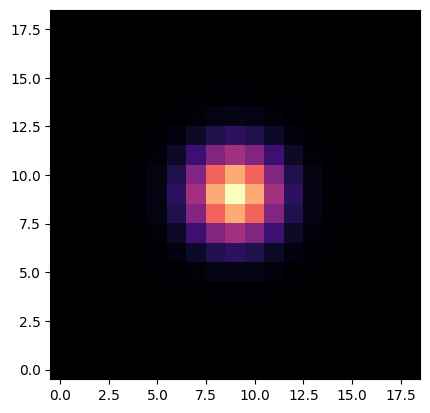

In [16]:
# Compute a Gaussian PSF kernel with given pixel scale, FWHM, and truncation (e.g. 6 * sigma)
kernel = psf.compute_gaussian_kernel(pix_scl, 0.3, 6)
plt.imshow(kernel, cmap='magma')


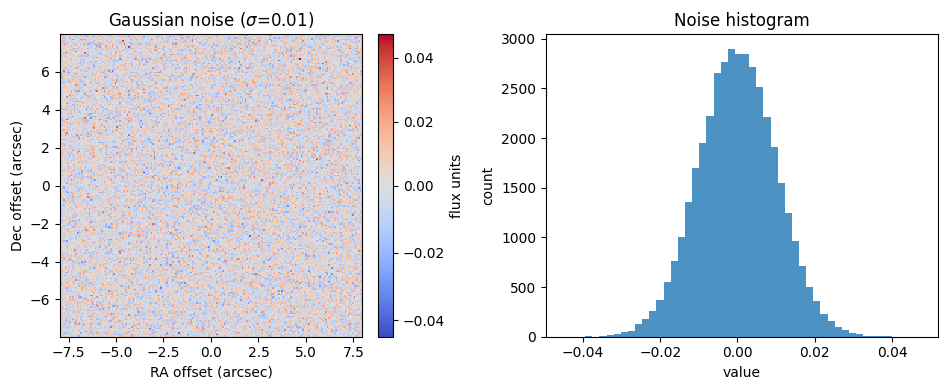

In [17]:
# Visualize background noise map (independent of `hcl.Noise` internals)
import numpy as np
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm


rng = np.random.default_rng(0)
noise_map = rng.normal(loc=0.0, scale=background_rms_simu, size=(npix, npix))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
im = ax.imshow(noise_map, origin='lower', cmap='coolwarm', norm=TwoSlopeNorm(0), extent=extent)
ax.set_title(rf"Gaussian noise ($\sigma$={background_rms_simu})")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='flux units')
ax.set_xlabel('RA offset (arcsec)')
ax.set_ylabel('Dec offset (arcsec)')

ax = axes[1]
ax.hist(noise_map.ravel(), bins=50, color='tab:blue', alpha=0.8)
ax.set_title('Noise histogram')
ax.set_xlabel('value')
ax.set_ylabel('count')

plt.tight_layout()
plt.show()


In [18]:
# Lens light
lens_light_model_input = hcl.LightModel([hcl.SersicElliptic()])
kwargs_lens_light_input = [
    {'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true}
]
#pprint(kwargs_lens_light_input)

# Source light
y1_em_true = 0.05
y2_em_true = 0.1
e1_em_s_true = 0.05
e2_em_s_true = 0.05 
source_model_input = hcl.LightModel([hcl.SersicElliptic()])
kwargs_source_input = [
    {'amp': 4.0, 'R_sersic': 0.5, 'n_sersic': 2., 'e1': e1_em_s_true, 'e2': e2_em_s_true, 'center_x': y1_em_true, 'center_y': y2_em_true}
]


In [19]:
# Generate a lensed image based on source and lens models (Mock EM data)
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = hcl.LensImage(pixel_grid, psf, noise_class=noise_simu,
                         lens_mass_model_class=lens_mass_model,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_true_sie_shear_fixed,
                        kwargs_source=kwargs_source_input,
                        kwargs_lens_light=kwargs_lens_light_input)

# clean image (no noise)
image = lens_image_simu.model(**kwargs_all_input)

# simulated observation including noise
SEED = 87651  # fixes the stochasticity
key = jax.random.PRNGKey(SEED)
key, key_sim = jax.random.split(key)
data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, prng_key=key_sim)


In [20]:
# Plotting engine
plotter = hcl.Plotter(flux_vmin=8e-3, flux_vmax=6e-1)

# inform the plotter of the data and, if any, the true source 
plotter.set_data(data)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
plotter.set_ref_source(source_input)


In [21]:
xx, yy = pixel_grid.pixel_coordinates


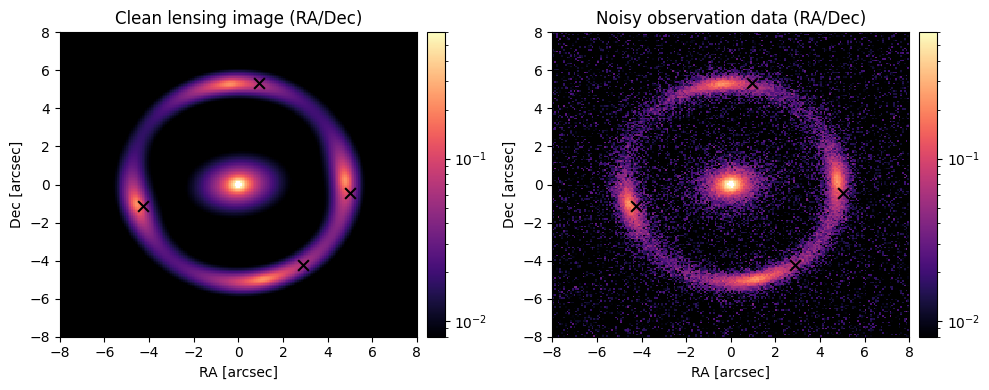

In [22]:
# visualize simulated products using the image grid xx and yy and scatter image positions

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot clean image
img1 = ax1.pcolormesh(xx, yy, image, shading='auto', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image (RA/Dec)")
ax1.set_xlabel("RA [arcsec]")
ax1.set_ylabel("Dec [arcsec]")

# Scatter the true image positions
ax1.scatter(x_image_true, y_image_true, color='black', marker='x', s=60)
# ax1.legend()

# Plot noisy data
img2 = ax2.pcolormesh(xx, yy, data, shading='auto', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img2)
ax2.set_title("Noisy observation data (RA/Dec)")
ax2.set_xlabel("RA [arcsec]")
ax2.set_ylabel("Dec [arcsec]")

# Scatter the true image positions
ax2.scatter(x_image_true, y_image_true, color='black', marker='x', s=60)
# ax2.legend()

fig.tight_layout()
plt.show()


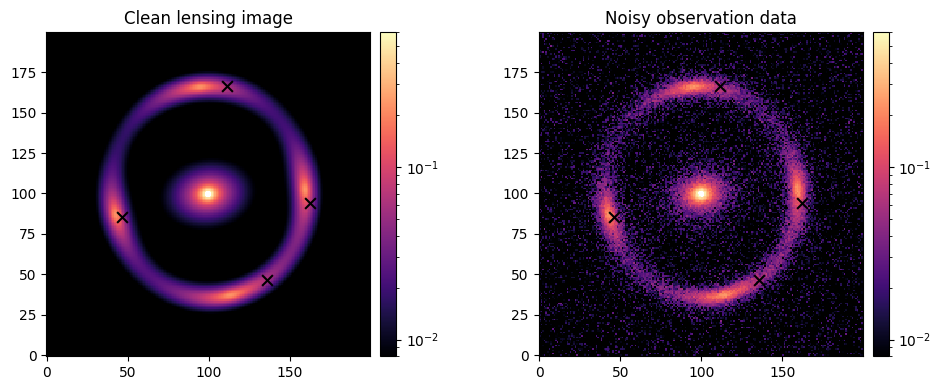

In [23]:
#Get pixel coordinate of gw images
x_pix_gw, y_pix_gw = pixel_grid.map_coord2pix(x_image_true, y_image_true)

# visualize simulated products
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image")
ax1.scatter(x_pix_gw, y_pix_gw, color='black', marker='x', s=60, label='GW')
img2 = ax2.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data")
plot_util.nice_colorbar(img2)
ax2.scatter(x_pix_gw, y_pix_gw, color='black', marker='x', s=60, label='GW')
fig.tight_layout()
plt.show()


In [24]:
kwargs_numerics_fit = {'supersampling_factor': 2}
lens_image = hcl.LensImage(deepcopy(pixel_grid), deepcopy(psf), noise_class=deepcopy(noise),
                         lens_mass_model_class=deepcopy(lens_mass_model),
                         source_model_class=deepcopy(source_model_input),
                         lens_light_model_class=deepcopy(lens_light_model_input),
                         kwargs_numerics=kwargs_numerics_fit)


In [25]:
tarrival_lt = lensModel.arrival_time(x_image_true,y_image_true,kwargs_lens_true_sie_shear_fixed)
phi_lt = lensModel.fermat_potential(x_image_true,y_image_true,kwargs_lens_true_sie_shear_fixed)
magnifications_lt = lensModel.magnification(x_image_true,y_image_true,kwargs_lens_true_sie_shear_fixed)
print(phi_lt)
print(magnifications_lt)

print(tarrival_lt)
print(jnp.diff(tarrival_lt)) # in days


[-14.59051491 -13.0588558  -12.63044923  -9.60442232]
[ 5.46367268  8.66928312 -8.06563393 -3.26537798]
[-1255.59720402 -1123.78918267 -1086.92234911  -826.51543686]
[131.80802135  36.86683357 260.40691225]


In [26]:
# Create  a mock GW observation
# arcsecond_to_radians = (1*u.arcsecond).to(u.radian).value #4.84814e-6 
time_delay_distance_true = jax_cosmo.time_delay_distance(zl_true, zs_true) #with Mpc unit
print('Time delay distance (D_dt) (in Mpc) [(1+zl)Ds*Dd/Dds]:', time_delay_distance_true)

x_image_true = jnp.array(x_image_true)
y_image_true = jnp.array(y_image_true)

lens_gw = lensimage_gw.LensImageGW(lens_mass_model)
data_GW = lens_gw.compute(x_image_true,y_image_true,kwargs_lens_true_sie_shear,time_delay_distance_true)

print(data_GW)

dL_true = jax_cosmo.luminosity_distance(zs_true)
magnifications_true = data_GW['mu']
dL_effectives_true = dL_true/jnp.sqrt(jnp.abs(magnifications_true))
time_delays_true = data_GW['time_delays_in_seconds']
gw_obs = {
    'time_delays': time_delays_true, 
    'dL_eff': dL_effectives_true
}

print(gw_obs)


Time delay distance (D_dt) (in Mpc) [(1+zl)Ds*Dd/Dds]: 3088.8635805953318
{'beta_x': Array([0.3, 0.3, 0.3, 0.3], dtype=float64), 'beta_y': Array([0.2, 0.2, 0.2, 0.2], dtype=float64), 'psi': Array([27.96359333, 26.22108648, 23.97204131, 20.83697923], dtype=float64), 'mu': Array([ 5.4636646 ,  8.66926348, -8.06538814, -3.26536634], dtype=float64), 'phi_in_arcsecsq': Array([-14.59051491, -13.0588558 , -12.63044923,  -9.60442232], dtype=float64), 'Tstar_in_seconds': Array(7472713.02060066, dtype=float64), 'tarrivals_in_seconds': Array([-1.09030731e+08, -9.75850817e+07, -9.43837224e+07, -7.17710917e+07],      dtype=float64), 'tarrivals_days': Array([-1261.92975406, -1129.45696468, -1092.40419483,  -830.68393161],      dtype=float64), 'time_delays_in_seconds': Array([11445649.00293511,  3201359.31445333, 22612630.74202657], dtype=float64), 'time_delays_in_days': Array([132.47278939,  37.05276984, 261.72026322], dtype=float64)}
{'time_delays': Array([11445649.00293511,  3201359.31445333, 2261

In [27]:
em_obs = {'data':data}
print(em_obs['data'].shape)
gw_obs

(200, 200)


{'time_delays': Array([11445649.00293511,  3201359.31445333, 22612630.74202657], dtype=float64),
 'dL_eff': Array([6822.27176334, 5416.01589014, 5615.11163248, 8824.80412962],      dtype=float64)}

In [57]:
class ProbModel(hcl.NumpyroModel):
    def __init__(self, n_images=4, gw_observations=None, em_observations=None):
    
        self.n_images = n_images
        self.gw_observations = gw_observations or {}
        self.em_observations = em_observations or {}
        super().__init__()
        
        # Store likelihood values
        self.em_loglike = 0.0
        self.gw_loglike = 0.0
        self.prior_loglike = 0.0
        self.combined_loglike = 0.0

    def model(self):
        # Track prior contributions
        prior_loglike = 0.0
        zs = numpyro.sample('zs', dist.Uniform(1.0, 10.0))
        prior_loglike += dist.Uniform(1.0, 10.0).log_prob(zs)
        
        zl = numpyro.sample('zl', dist.Uniform(0.0, zs-0.0001))
        prior_loglike += dist.Uniform(0.0, zs-0.0001).log_prob(zl)
        
        # Image positions
        image_positions = []
        x_pos_array = []
        y_pos_array = []
        for i in range(self.n_images):
            # X positions
            x_pos = numpyro.sample(f'image_x{i+1}', dist.Uniform(-10, 10))
            prior_loglike += dist.Uniform(-10, 10).log_prob(x_pos)
            
            # Y positions
            y_pos = numpyro.sample(f'image_y{i+1}', dist.Uniform(-10, 10))
            prior_loglike += dist.Uniform(-10, 10).log_prob(y_pos)
            
            image_positions.append((x_pos, y_pos))
            x_pos_array.append(x_pos)
            y_pos_array.append(y_pos)
        
        x_pos_array = jnp.array(x_pos_array)
        y_pos_array = jnp.array(y_pos_array)
        # Parameters of the source
        source_amp = numpyro.sample('source_amp', dist.TruncatedNormal(4.0, 1.0, low=0.0, high=10.0))
        prior_loglike += dist.TruncatedNormal(4.0, 1.0, low=0.0, high=10.0).log_prob(source_amp)
        
        source_R_sersic = numpyro.sample('source_R_sersic', dist.TruncatedNormal(0.5, 0.4, low=0.05))
        prior_loglike += dist.TruncatedNormal(0.5, 0.4, low=0.05).log_prob(source_R_sersic)
        
        source_n = numpyro.sample('source_n', dist.Uniform(1., 3.))
        prior_loglike += dist.Uniform(1., 3.).log_prob(source_n)
        
        source_e1 = numpyro.sample('source_e1', dist.TruncatedNormal(0.05, 0.06, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0.0, 0.05, low=-0.3, high=0.3).log_prob(source_e1)
        
        source_e2 = numpyro.sample('source_e2', dist.TruncatedNormal(0.05, 0.06, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0.0, 0.05, low=-0.3, high=0.3).log_prob(source_e2)
        
        source_center_x = numpyro.sample('source_center_x', dist.Normal(0.05, 0.02))
        prior_loglike += dist.Normal(0.05, 0.02).log_prob(source_center_x)
        
        source_center_y = numpyro.sample('source_center_y', dist.Normal(0.1, 0.02))
        prior_loglike += dist.Normal(0.1, 0.02).log_prob(source_center_y)
        
        prior_source = [
            {'amp': source_amp,
            'R_sersic': source_R_sersic, 
            'n_sersic': source_n, 
            'e1': source_e1,
            'e2': source_e2,
            'center_x': source_center_x, 
            'center_y': source_center_y}
            ]

        # Parameters of the lens light that are used for the lens mass
        cx = numpyro.sample('light_center_x', dist.Normal(0., pix_scl/2.))
        prior_loglike += dist.Normal(0., pix_scl/2.).log_prob(cx)
        
        cy = numpyro.sample('light_center_y', dist.Normal(0., pix_scl/2.))
        prior_loglike += dist.Normal(0., pix_scl/2.).log_prob(cy)
        
        e1 = numpyro.sample('light_e1', dist.TruncatedNormal(0., 0.2, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0., 0.2, low=-0.3, high=0.3).log_prob(e1)
        
        e2 = numpyro.sample('light_e2', dist.TruncatedNormal(0., 0.2, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0., 0.2, low=-0.3, high=0.3).log_prob(e2)

        # Parameters of the lens light, with center relative the lens mass
        light_amp = numpyro.sample('light_amp', dist.TruncatedNormal(8, 2.0, low=0.0, high=15.0))
        prior_loglike += dist.TruncatedNormal(8, 2.0, low=0.0, high=15.0).log_prob(light_amp)
        
        light_R_sersic = numpyro.sample('light_R_sersic', dist.Normal(1.0, 0.5))
        prior_loglike += dist.Normal(1.0, 0.5).log_prob(light_R_sersic)
        
        light_n = numpyro.sample('light_n', dist.Uniform(2., 5.))
        prior_loglike += dist.Uniform(2., 5.).log_prob(light_n)
        
        prior_lens_light = [
            {'amp': light_amp, 
            'R_sersic': light_R_sersic, 
            'n_sersic': light_n, 
            'e1': e1,
            'e2': e2,
            'center_x': cx, 
            'center_y': cy}
            ]

        # Lens mass parameters
        lens_theta_E = numpyro.sample('lens_theta_E', dist.TruncatedNormal(5, 2, low=0.01, high=10.0))
        prior_loglike += dist.TruncatedNormal(5, 2, low=0.01, high=10.0).log_prob(lens_theta_E)
        
        lens_e1 = numpyro.sample('lens_e1', dist.Normal(e1, 0.05))
        prior_loglike += dist.Normal(e1, 0.05).log_prob(lens_e1)
        
        lens_e2 = numpyro.sample('lens_e2', dist.Normal(e2, 0.05))
        prior_loglike += dist.Normal(e2, 0.05).log_prob(lens_e2)
        
        lens_center_x = numpyro.sample('lens_center_x', dist.Normal(cx, 0.05))
        prior_loglike += dist.Normal(cx, 0.05).log_prob(lens_center_x)
        
        lens_center_y = numpyro.sample('lens_center_y', dist.Normal(cy, 0.05))
        prior_loglike += dist.Normal(cy, 0.05).log_prob(lens_center_y)
        
        # External shear parameters
        gamma1 = numpyro.sample('lens_gamma1', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3).log_prob(gamma1)
        
        gamma2 = numpyro.sample('lens_gamma2', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3).log_prob(gamma2)
        
        sigma_bkg = numpyro.sample('noise_sigma_bkg', dist.Uniform(low=1e-3, high=1e-1))
        prior_loglike += dist.Uniform(low=1e-3, high=1e-1).log_prob(sigma_bkg)

        prior_lens = [
            {'theta_E': lens_theta_E,
            'e1': lens_e1,
            'e2': lens_e2,
            'center_x': lens_center_x, 
            'center_y': lens_center_y},
            # external shear, with fixed origin
            {'gamma1': gamma1, 
            'gamma2': gamma2, 
            'ra_0': 0.0, 'dec_0': 0.0}
            ]        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_lens_light=prior_lens_light,
                            kwargs_source=prior_source)
        
        

        if self.em_observations:
            # generates the model image
            model_image = lens_image.model(**model_params)
            data = self.em_observations['data']
            # estimate the error per pixel
            
            
            model_var = noise.C_D_model(model_image, background_rms=sigma_bkg)
            model_std = jnp.sqrt(model_var)

            # EM likelihood (already included in the sample statement below)
            em_loglike = dist.Independent(dist.Normal(model_image, model_std), 2).log_prob(data)

            self.em_loglike = em_loglike
            # jax.debug.print("EM log-likelihood: {em_loglike}", em_loglike=em_loglike)
            # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
            numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_std), 2), obs=data)
        else:
            self.em_loglike = 0.0

        if self.gw_observations:
            D_dt_model = jax_cosmo.time_delay_distance(zl,zs)
            dL_model = jax_cosmo.luminosity_distance(zs)
            model_gw = lens_gw.compute(x_pos_array,y_pos_array,prior_lens,D_dt_model)
            beta_x = model_gw['beta_x']
            beta_y = model_gw['beta_y']
            betx_x_diff = jnp.diff(beta_x)
            bety_y_diff = jnp.diff(beta_y)
            zeros = jnp.zeros_like(betx_x_diff) 
            ones = jnp.ones_like(betx_x_diff)

            model_time_delays = model_gw['time_delays_in_seconds']
            model_magnifications = model_gw['mu']
            model_dL_eff = dL_model/jnp.sqrt(jnp.abs(model_magnifications))

            # jax.debug.print("model_dL_eff: {model_dL_eff}", model_dL_eff=model_dL_eff-dL_effectives_true)
            # jax.debug.print("model_time_delays: {model_time_delays}", model_time_delays=model_time_delays-time_delays_true)
            # jax.debug.print("model_magnifications: {model_magnifications}", model_magnifications=model_magnifications-magnifications_true)

            # GW likelihood
            sigma_td = 0.05 * time_delays_true
            sigma_dL_eff = 0.05 * dL_effectives_true
            epsilon = 0.005*ones

            numpyro.sample('tdelays_obs', dist.Independent(dist.Normal(model_time_delays, sigma_td), 1), obs=time_delays_true)
            numpyro.sample('dL_eff_obs', dist.Independent(dist.Normal(model_dL_eff, sigma_dL_eff), 1), obs=dL_effectives_true)
            numpyro.sample('betx_x_diff', dist.Independent(dist.Normal(zeros, epsilon), 1), obs=betx_x_diff)
            numpyro.sample('bety_y_diff', dist.Independent(dist.Normal(zeros, epsilon), 1), obs=bety_y_diff)

            loglike_td = dist.Independent(dist.Normal(model_time_delays, sigma_td), 1).log_prob(time_delays_true)
            loglike_dL_eff = dist.Independent(dist.Normal(model_dL_eff, sigma_dL_eff), 1).log_prob(dL_effectives_true)
            loglike_betx_x_diff = dist.Independent(dist.Normal(zeros, epsilon), 1).log_prob(betx_x_diff)
            loglike_bety_y_diff = dist.Independent(dist.Normal(zeros, epsilon), 1).log_prob(bety_y_diff)

            loglike_gw = loglike_td + loglike_dL_eff + loglike_betx_x_diff + loglike_bety_y_diff
            # gw_logprob = self._compute_gw_logprob(zl,zs,image_positions, prior_lens)
            # This line adds the computed GW log-likelihood (gw_loglike) to the model's total log-probability.
            # It effectively incorporates the GW likelihood as an unnormalized factor in the probabilistic model.
            # numpyro.factor('gw_likelihood', gw_logprob)
            self.gw_loglike = loglike_gw
            # jax.debug.print("GW log-likelihood: {gw_loglike}", gw_loglike=loglike_gw)
        else:
            self.gw_loglike = 0.0
        
        self.prior_loglike = prior_loglike
        # jax.debug.print("Prior log-likelihood: {prior_loglike}", prior_loglike=self.prior_loglike)
        # jax.debug.print("EM log-likelihood: {em_loglike}", em_loglike=self.em_loglike)
        # jax.debug.print("GW log-likelihood: {gw_loglike}", gw_loglike=self.gw_loglike)
        
        # Combined likelihood (prior + EM + GW)
        
        combined_loglike = self.prior_loglike + self.em_loglike + self.gw_loglike
        self.combined_loglike = combined_loglike
        # jax.debug.print("Combined log-likelihood: {combined_loglike}", combined_loglike=self.combined_loglike)


    
    def params2kwargs(self, params):
        # functions that takes the flatten dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        kw = {'kwargs_lens': [{'theta_E': params['lens_theta_E'],
        'e1': params['lens_e1'],
        'e2': params['lens_e2'],
        'center_x': params['lens_center_x'],
        'center_y': params['lens_center_y']},
        {'gamma1': params['lens_gamma1'],
        'gamma2': params['lens_gamma2'],
        'ra_0': 0.0,
        'dec_0': 0.0}],
        'kwargs_source': [{'amp': params['source_amp'],
        'R_sersic': params['source_R_sersic'],
        'n_sersic': params['source_n'],
        'e1': params['source_e1'],
        'e2': params['source_e2'],
        'center_x': params['source_center_x'],
        'center_y': params['source_center_y']}],
        'kwargs_lens_light': [{'amp': params['light_amp'],
        'R_sersic': params['light_R_sersic'],
        'n_sersic': params['light_n'],
        'e1': params['light_e1'],
        'e2': params['light_e2'],
        'center_x': params['light_center_x'],
        'center_y': params['light_center_y']}],
        'zs': params['zs'],
        'zl': params['zl'],
        'image_positions': [
                (params.get(f'image_x{i+1}', 0.0),
                params.get(f'image_y{i+1}', 0.0))
                for i in range(self.n_images)
            ]
        }
        return kw
    
    def get_likelihoods(self):
        """Return the computed likelihood values"""
        # jax.debug.print("Getting likelihoods")
        # jax.debug.print(self.prior_loglike)
        # jax.debug.print(self.em_loglike)
        # jax.debug.print(self.gw_loglike)
        # jax.debug.print(self.combined_loglike)
        return {
            'prior_loglike': self.prior_loglike,
            'em_loglike': self.em_loglike,
            'gw_loglike': self.gw_loglike, 
            'combined_loglike': self.combined_loglike
        }

prob_model = ProbModel()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)


Number of parameters: 32


In [58]:
gw_model = ProbModel(n_images=4, gw_observations=gw_obs)
print(gw_model.num_parameters)
print("GW Model created with", gw_model.num_parameters, "parameters")
print('*'*100)
em_model = ProbModel(n_images=4, em_observations=em_obs)
print(em_model.num_parameters)
print("EM Model created with", em_model.num_parameters, "parameters")
print('*'*100)

# Create GW model with no fixed parameters
gw_em_model = ProbModel(n_images=4, gw_observations=gw_obs, em_observations=em_obs)
print(gw_em_model.num_parameters)
print("GW-EM Model created with", gw_em_model.num_parameters, "parameters")


32
GW Model created with 32 parameters
****************************************************************************************************
32
EM Model created with 32 parameters
****************************************************************************************************
32
GW-EM Model created with 32 parameters


In [59]:
# create the input vector for reference
input_params = {
    'zs': zs_true,
    'zl': zl_true,
    'image_x1': x_image_true[0],
    'image_y1': y_image_true[0],
    'image_x2': x_image_true[1],
    'image_y2': y_image_true[1],
    'image_x3': x_image_true[2],
    'image_y3': y_image_true[2],
    'image_x4': x_image_true[3],
    'image_y4': y_image_true[3],
    'lens_theta_E': kwargs_all_input['kwargs_lens'][0]['theta_E'],
    'lens_e1': kwargs_all_input['kwargs_lens'][0]['e1'],
    'lens_e2': kwargs_all_input['kwargs_lens'][0]['e2'],
    'lens_center_x': kwargs_all_input['kwargs_lens'][0]['center_x'],
    'lens_center_y': kwargs_all_input['kwargs_lens'][0]['center_y'],
    'lens_gamma1': kwargs_all_input['kwargs_lens'][1]['gamma1'],
    'lens_gamma2': kwargs_all_input['kwargs_lens'][1]['gamma2'],
    'light_amp': kwargs_all_input['kwargs_lens_light'][0]['amp'],
    'light_R_sersic': kwargs_all_input['kwargs_lens_light'][0]['R_sersic'],
    'light_n': kwargs_all_input['kwargs_lens_light'][0]['n_sersic'],
    'light_e1': kwargs_all_input['kwargs_lens_light'][0]['e1'],
    'light_e2': kwargs_all_input['kwargs_lens_light'][0]['e2'],
    'light_center_x': kwargs_all_input['kwargs_lens_light'][0]['center_x'],
    'light_center_y': kwargs_all_input['kwargs_lens_light'][0]['center_y'],
    'source_amp': kwargs_all_input['kwargs_source'][0]['amp'],
    'source_R_sersic': kwargs_all_input['kwargs_source'][0]['R_sersic'],
    'source_n': kwargs_all_input['kwargs_source'][0]['n_sersic'],
    'source_e1': kwargs_all_input['kwargs_source'][0]['e1'],
    'source_e2': kwargs_all_input['kwargs_source'][0]['e2'],
    'source_center_x': kwargs_all_input['kwargs_source'][0]['center_x'],
    'source_center_y': kwargs_all_input['kwargs_source'][0]['center_y'],
    'noise_sigma_bkg': background_rms_simu,
}

# input_params

input_params_flat = jnp.array(list(input_params.values()))

len(input_params_flat)

32

In [60]:
from numpyro.handlers import seed
# access the trace element
trace = numpyro.handlers.trace(seed(gw_model.model,key)).get_trace()
#print the keys of the trace
print(trace.keys())

print('zs', trace['zs']['value'])
print('zl', trace['zl']['value'])
print('image_x1', trace['image_x1']['value'])
print('image_y1', trace['image_y1']['value'])
print('image_x2', trace['image_x2']['value'])
print('image_y2', trace['image_y2']['value'])

print('time delay log-likelihood', trace['tdelays_obs']['value'])
print('dL_eff log-likelihood', trace['dL_eff_obs']['value'])
print('betx_x_diff log-likelihood', trace['betx_x_diff']['value'])
print('bety_y_diff log-likelihood', trace['bety_y_diff']['value'])

print('GW loglikelihood', gw_model.log_prob(input_params))
print('GW alternative loglikelihood', gw_model.get_likelihoods())




odict_keys(['zs', 'zl', 'image_x1', 'image_y1', 'image_x2', 'image_y2', 'image_x3', 'image_y3', 'image_x4', 'image_y4', 'source_amp', 'source_R_sersic', 'source_n', 'source_e1', 'source_e2', 'source_center_x', 'source_center_y', 'light_center_x', 'light_center_y', 'light_e1', 'light_e2', 'light_amp', 'light_R_sersic', 'light_n', 'lens_theta_E', 'lens_e1', 'lens_e2', 'lens_center_x', 'lens_center_y', 'lens_gamma1', 'lens_gamma2', 'noise_sigma_bkg', 'tdelays_obs', 'dL_eff_obs', 'betx_x_diff', 'bety_y_diff'])
zs 7.679071096999285
zl 5.058750740425965
image_x1 3.749104398144465
image_y1 8.81274614627078
image_x2 -0.16706603290550515
image_y2 2.523675781753427
time delay log-likelihood [11445649.00293511  3201359.31445333 22612630.74202657]
dL_eff log-likelihood [6822.27176334 5416.01589014 5615.11163248 8824.80412962]
betx_x_diff log-likelihood [-5.14273948  2.60488441 -0.39418386]
bety_y_diff log-likelihood [10.85033133 -0.74704355 -7.44727618]
GW loglikelihood -22766676.298708737
GW alte

In [61]:
with numpyro.handlers.substitute(data=input_params):
    with numpyro.handlers.seed(rng_seed=42):
        trace = numpyro.handlers.trace(gw_model.model).get_trace()

In [62]:
print('time delay log-likelihood:', trace['tdelays_obs']['fn'].log_prob(trace['tdelays_obs']['value']))

time delay log-likelihood: -41.935844248811875


In [ ]:
# These are sampled values
print('time delay log-likelihood', trace['tdelays_obs']['value'])
print('dL_eff log-likelihood', trace['dL_eff_obs']['value'])
print('betx_x_diff log-likelihood', trace['betx_x_diff']['value'])
print('bety_y_diff log-likelihood', trace['bety_y_diff']['value'])

print('GW loglikelihood', gw_model.log_prob(input_params))
print('GW alternative loglikelihood', gw_model.get_likelihoods())


time delay log-likelihood [11445649.00293511  3201359.31445333 22612630.74202657]
dL_eff log-likelihood [6822.27176334 5416.01589014 5615.11163248 8824.80412962]
betx_x_diff log-likelihood [-3.03871373e-11 -3.68567399e-11  3.96997990e-11]
bety_y_diff log-likelihood [-1.75504056e-12 -3.74054676e-11  3.09826054e-11]
model_dL_eff: [43969.31727079  1945.03505957 30748.7510111  18441.37581345]
model_time_delays: [3.75020890e+09 9.35791569e+07 1.17292603e+09]
model_magnifications: [  -2.09854854 -168.88456814   14.63052268   -8.41173513]
GW loglikelihood -22766676.298708737
GW alternative loglikelihood {'prior_loglike': Array(-38.12731785, dtype=float64), 'em_loglike': 0.0, 'gw_loglike': Array(-22766607.46291808, dtype=float64), 'combined_loglike': Array(-22766645.59023593, dtype=float64)}


In [67]:
from numpyro.infer.util import potential_energy

# Empty dict for model params (no latent variables to condition on)
potential_energy??#(gw_model.model, {}, input_params)

# print(f"Potential energy: {pe}")
# This is -log_likelihood (since no priors are evaluated)
# So: log_likelihood = -pe

SyntaxError: invalid syntax (469277192.py, line 4)

In [74]:
from numpyro.infer.util import log_likelihood

# This automatically computes log-likelihood for all observed sites
log_liks = log_likelihood(gw_model.model, input_params)
print(log_liks['tdelays_obs'])
print(log_liks['dL_eff_obs'])
print(log_liks['betx_x_diff'])
print(log_liks['bety_y_diff'])
# Sum everything
total = sum(jnp.sum(v) for v in log_liks.values())
print(f"Total log-likelihood: {total}")

-41.935844248811875
-26.836427020320805
13.138136500030093
13.138136500030093
Total log-likelihood: -42.495998269072494


In [75]:
with numpyro.handlers.substitute(data=input_params):
    with numpyro.handlers.seed(rng_seed=42):
        trace = numpyro.handlers.trace(gw_model.model).get_trace()

# Sum log probabilities from all sample sites
total_log_prob = 0.0

for site_name, site in trace.items():
    if site['type'] == 'sample':
        # Compute log probability
        log_prob = site['fn'].log_prob(site['value'])
        
        # Handle arrays vs scalars
        site_log_prob = jnp.sum(log_prob)  # Sum if it's an array
        
        print(f"{site_name}: {site_log_prob}")
        total_log_prob += site_log_prob

print(f"\nTotal log probability: {total_log_prob}")

zs: -2.1972245773362196
zl: -0.6930971793099037
image_x1: -2.995732273553991
image_y1: -2.995732273553991
image_x2: -2.995732273553991
image_y2: -2.995732273553991
image_x3: -2.995732273553991
image_y3: -2.995732273553991
image_x4: -2.995732273553991
image_y4: -2.995732273553991
source_amp: -0.9189068604746763
source_R_sersic: 0.1369528487602711
source_n: -0.6931471805599453
source_e1: 1.8944876406882507
source_e2: 1.8944876406882507
source_center_x: 2.9930844722234733
source_center_y: 2.9930844722234733
light_center_x: 2.2999372916635283
light_center_y: 2.2999372916635283
light_e1: 0.5982041656624892
light_e2: 0.8145429657023939
light_amp: -1.611821378510264
light_R_sersic: -0.22579135264472733
light_n: -1.0986122886681098
lens_theta_E: -1.5994993144813765
lens_e1: 2.076793740349318
lens_e2: 2.076793740349318
lens_center_x: 2.076793740349318
lens_center_y: 2.076793740349318
lens_gamma1: 1.3863499591290975
lens_gamma2: 1.3863495546206004
noise_sigma_bkg: 2.312635428847547
tdelays_obs: 

In [84]:
from numpyro.infer.util import potential_energy

pe = potential_energy(
    gw_model.model,          # model
    (),                      # model_args (tuple)
    {},                      # model_kwargs (dict)
    init_params_unconst      # params (unconstrained parameters)
)

print(f"Potential energy: {pe}")

Potential energy: 50.82439700331743


In [86]:
from numpyro.infer.util import potential_energy

pe = potential_energy(
    gw_model.model,          # model
    (),                      # model_args (tuple)
    {},                      # model_kwargs (dict)
    init_params_unconst      # params (unconstrained parameters)
)

print(f"Potential energy: {pe}")

Potential energy: 50.82439700331743


In [70]:
# from fisher import FisherMatrix

In [71]:
# # Initiate the class FisherMatrix
# fisher_class_gw = FisherMatrix(gw_model, lens_mass_model, kwargs_lens_true_sie_shear, jnp.array([y0true,y1true]), x_image_true, y_image_true)
# fisher_class_em = FisherMatrix(em_model, lens_mass_model, kwargs_lens_true_sie_shear, jnp.array([y0true,y1true]), x_image_true, y_image_true)
# fisher_class_gw_em = FisherMatrix(gw_em_model, lens_mass_model, kwargs_lens_true_sie_shear, jnp.array([y0true,y1true]), x_image_true, y_image_true)

In [65]:
# gw_model.params2kwargs(input_params)

In [67]:
# key, key_init = jax.random.split(key)
# init_params = gw_model.get_sample(key_init)  # constrained space
# init_params_unconst = gw_model.unconstrain(init_params)  # UNconstrained space
# kwargs_init = gw_model.params2kwargs(init_params)  # constrained space

In [70]:
init_params = input_params
init_params_unconst = gw_model.unconstrain(init_params)
kwargs_init = gw_model.params2kwargs(init_params)

In [71]:
loss = hcl.Loss(gw_model)
print("Initial loss =", loss(init_params_unconst))

Initial loss = 50.82439709062763


In [78]:
@jax.jit
def logdensity_fn(args):
    return -loss(args)

# Fix: Remove progress_bar=True to avoid the KeyError
adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, 
    target_acceptance_rate=0.8, 
    is_mass_matrix_diagonal=True,
    initial_step_size=1.0,
    # progress_bar=True,  # Commented out to fix the error
)

num_steps_adaptation = 8

key, key_hmc_adapt, key_hmc_run = jax.random.split(key, 3)

start = time.time()
(last_state, adapted_settings), info = adapt.run(key_hmc_adapt, init_params_unconst, 
                                                 num_steps=num_steps_adaptation)
print("Time taken by HMC (blackjax) warmup phase:", time.time()-start)

print("Warmup state (lens only, unconstrained)", {k: v for k, v in last_state.position.items() if 'lens' in k})

Time taken by HMC (blackjax) warmup phase: 13.083112955093384
Warmup state (lens only, unconstrained) {'lens_center_x': Array(-0.00893703, dtype=float64, weak_type=True), 'lens_center_y': Array(-0.05339724, dtype=float64, weak_type=True), 'lens_e1': Array(-0.06797881, dtype=float64, weak_type=True), 'lens_e2': Array(0.16186788, dtype=float64, weak_type=True), 'lens_gamma1': Array(-0.58607648, dtype=float64, weak_type=True), 'lens_gamma2': Array(0.0636613, dtype=float64, weak_type=True), 'lens_theta_E': Array(0.28462779, dtype=float64, weak_type=True)}


In [87]:
from jax import random

from numpyro.infer import MCMC, NUTS


In [ ]:
nuts_kernel = NUTS(logdensity_fn)

In [89]:
mcmc = MCMC(nuts_kernel, num_warmup=5, num_samples=10)

In [76]:
# mcmc.run(key, extra_fields=('potential_energy',))


In [ ]:
# Simplest working solution - just use the standard BlackJAX approach
import tqdm

@jax.jit
def logdensity_fn(args):
    return -loss(args)

# Manual adaptation with real progress bar
num_steps_adaptation = 8
key, key_hmc_adapt, key_hmc_run = jax.random.split(key, 3)

print("Starting HMC adaptation with progress bar...")
start = time.time()

# Use the window adaptation approach (simpler and more reliable)
adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, 
    target_acceptance_rate=0.8, 
    is_mass_matrix_diagonal=True,
    initial_step_size=1.0,
)

# Create simple progress bar (no ipywidgets required)
pbar = tqdm.tqdm(total=num_steps_adaptation, desc="HMC Adaptation", unit="step")

# Manual adaptation loop with progress tracking
def run_adaptation_with_progress():
    # Initialize adaptation state using the correct API
    adaptation_state = blackjax.window_adaptation.init_state(
        blackjax.nuts(logdensity_fn), init_params_unconst, target_acceptance_rate=0.8
    )
    
    for i in range(num_steps_adaptation):
        key_adapt, key_hmc_adapt = jax.random.split(key_hmc_adapt)
        
        # Run one adaptation step
        adaptation_state, info = blackjax.window_adaptation.step(
            adaptation_state, blackjax.nuts(logdensity_fn), key_adapt, init_params_unconst
        )
        
        # Update progress bar with current info
        pbar.update(1)
        pbar.set_postfix({
            'step_size': f"{float(adaptation_state.step_size):.4f}",
            'step': f"{i+1}/{num_steps_adaptation}"
        })
    
    return adaptation_state

# Run adaptation
adaptation_state = run_adaptation_with_progress()
pbar.close()

# Get the final adapted settings
adapted_settings = blackjax.window_adaptation.finalize(adaptation_state)
last_state = adaptation_state.state

print(f"Time taken by HMC (blackjax) warmup phase: {time.time()-start:.2f} seconds")
print("Warmup state (lens only, unconstrained)", {k: v for k, v in last_state.position.items() if 'lens' in k})


In [ ]:
# Simple BlackJAX implementation with progress bar (working version)
import tqdm

@jax.jit
def logdensity_fn(args):
    return -loss(args)

# Manual adaptation with real progress bar
num_steps_adaptation = 8
key, key_hmc_adapt, key_hmc_run = jax.random.split(key, 3)

print("Starting HMC adaptation with progress bar...")
start = time.time()

# Use the window adaptation approach (simpler and more reliable)
adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, 
    target_acceptance_rate=0.8, 
    is_mass_matrix_diagonal=True,
    initial_step_size=1.0,
)

# Create simple progress bar (no ipywidgets required)
pbar = tqdm.tqdm(total=num_steps_adaptation, desc="HMC Adaptation", unit="step")

# Manual adaptation loop with progress tracking
def run_adaptation_with_progress():
    # Initialize adaptation state using the correct API
    adaptation_state = blackjax.window_adaptation.init_state(
        blackjax.nuts(logdensity_fn), init_params_unconst, target_acceptance_rate=0.8
    )
    
    for i in range(num_steps_adaptation):
        key_adapt, key_hmc_adapt = jax.random.split(key_hmc_adapt)
        
        # Run one adaptation step
        adaptation_state, info = blackjax.window_adaptation.step(
            adaptation_state, blackjax.nuts(logdensity_fn), key_adapt, init_params_unconst
        )
        
        # Update progress bar with current info
        pbar.update(1)
        pbar.set_postfix({
            'step_size': f"{float(adaptation_state.step_size):.4f}",
            'step': f"{i+1}/{num_steps_adaptation}"
        })
    
    return adaptation_state

# Run adaptation
adaptation_state = run_adaptation_with_progress()
pbar.close()

# Get the final adapted settings
adapted_settings = blackjax.window_adaptation.finalize(adaptation_state)
last_state = adaptation_state.state

print(f"Time taken by HMC (blackjax) warmup phase: {time.time()-start:.2f} seconds")
print("Warmup state (lens only, unconstrained)", {k: v for k, v in last_state.position.items() if 'lens' in k})


In [ ]:
# Much simpler working solution - just use the standard BlackJAX approach
import tqdm

@jax.jit
def logdensity_fn(args):
    return -loss(args)

# Manual adaptation with real progress bar
num_steps_adaptation = 8
key, key_hmc_adapt, key_hmc_run = jax.random.split(key, 3)

print("Starting HMC adaptation with progress bar...")
start = time.time()

# Use the window adaptation approach (simpler and more reliable)
adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, 
    target_acceptance_rate=0.8, 
    is_mass_matrix_diagonal=True,
    initial_step_size=1.0,
)

# Create simple progress bar (no ipywidgets required)
pbar = tqdm.tqdm(total=num_steps_adaptation, desc="HMC Adaptation", unit="step")

# Manual adaptation loop with progress tracking
def run_adaptation_with_progress():
    # Initialize adaptation state using the correct API
    adaptation_state = blackjax.window_adaptation.init_state(
        blackjax.nuts(logdensity_fn), init_params_unconst, target_acceptance_rate=0.8
    )
    
    for i in range(num_steps_adaptation):
        key_adapt, key_hmc_adapt = jax.random.split(key_hmc_adapt)
        
        # Run one adaptation step
        adaptation_state, info = blackjax.window_adaptation.step(
            adaptation_state, blackjax.nuts(logdensity_fn), key_adapt, init_params_unconst
        )
        
        # Update progress bar with current info
        pbar.update(1)
        pbar.set_postfix({
            'step_size': f"{float(adaptation_state.step_size):.4f}",
            'step': f"{i+1}/{num_steps_adaptation}"
        })
    
    return adaptation_state

# Run adaptation
adaptation_state = run_adaptation_with_progress()
pbar.close()

# Get the final adapted settings
adapted_settings = blackjax.window_adaptation.finalize(adaptation_state)
last_state = adaptation_state.state

print(f"Time taken by HMC (blackjax) warmup phase: {time.time()-start:.2f} seconds")
print("Warmup state (lens only, unconstrained)", {k: v for k, v in last_state.position.items() if 'lens' in k})
